# How to use Tensorflow 2

Keras was designed as a high-level or meta API to accelerate the iterative workflow when designing and training deep neural networks with computational backends like TensorFlow, Theano, or CNTK. It has been integrated into TensorFlow in 2017 and is set to become the principal TensorFlow interface with the 2.0 release. You can also combine code from both libraries to leverage Keras’ high-level abstractions as well as customized TensorFlow graph operations.

Please follow the installations instructions in `Installation Guide.md` in the root folder.

## Imports & Settings 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd

import sklearn
from sklearn.datasets import make_circles # To generate the dataset

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D  # 3D plots

import seaborn as sns

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
# plotting style
sns.set_style('white')
# for reproducibility
np.random.seed(seed=42)

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [5]:
results_path = Path('results')
if not results_path.exists():
    results_path.mkdir()

## Input Data

### Generate random data

The target `y` represents two classes generated by two circular distribution that are not linearly separable because class 0 surrounds class 1.

In [6]:
# dataset params
N = 50000
factor = 0.1
noise = 0.1

In [7]:
# generate data
X, y = make_circles(
    n_samples=N,
    shuffle=True,
    factor=factor,
    noise=noise)

In [8]:
# define outcome matrix
Y = np.zeros((N, 2))
for c in [0, 1]:
    Y[y == c, c] = 1

In [9]:
f'Shape of: X: {X.shape} | Y: {Y.shape} | y: {y.shape}'

'Shape of: X: (50000, 2) | Y: (50000, 2) | y: (50000,)'

### Visualize Data

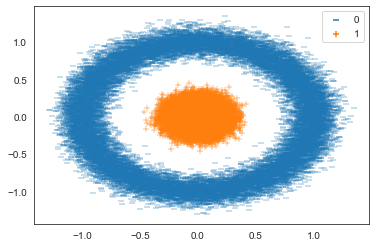

In [10]:
sns.scatterplot(x=X[:, 0], 
                y=X[:, 1], 
                hue=y,
               style=y,
               markers=['_', '+']);

## Build Keras Model

Keras supports both a slightly simpler Sequential and more flexible Functional API. We will introduce the former at this point and use the Functional API in more complex examples in the following chapters.

To create a model, we just need to instantiate a Sequential object and provide a list with the sequence of standard layers and their configurations, including the number of units, type of activation function, or name. 

### Define Architecture

In [11]:
model = Sequential([
    Dense(units=3, input_shape=(2,), name='hidden'),
    Activation('sigmoid', name='logistic'),
    Dense(2, name='output'),
    Activation('softmax', name='softmax'),
])

The first hidden layer needs information about the number of features in the matrix it receives from the input layer via the input_shape argument. In our simple case, these are just two. Keras infers the number of rows it needs to process during training, through the batch_size argument that we will pass to the fit method below. 

Keras infers the sizes of the inputs received by other layers from the previous layer’s units argument.

Keras provides numerous standard building blocks, including recurrent and convolutional layers, various options for regularization, a range of loss functions and optimizers, and also preprocessing, visualization and logging (see documentation on GitHub for reference). It is also extensible.

The model’s summary method produces a concise description of the network architecture, including a list of the layer types and shapes, and the number of parameters:

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 3)                 9         
_________________________________________________________________
logistic (Activation)        (None, 3)                 0         
_________________________________________________________________
output (Dense)               (None, 2)                 8         
_________________________________________________________________
softmax (Activation)         (None, 2)                 0         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


## Compile Model

Next, we compile the Sequential model to configure the learning process. To this end, we define the optimizer, the loss function, and one or several performance metrics to monitor during training:

In [13]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Tensorboard Callback

Keras uses callbacks to enable certain functionality during training, such as logging information for interactive display in TensorBoard (see next section):

In [14]:
tb_callback = TensorBoard(log_dir=results_path / 'tensorboard', 
                          histogram_freq=1, 
                          write_graph=True, 
                          write_images=True)

## Train Model

To train the model, we call its fit method and pass several parameters in addition to the training data:

In [ ]:
training=model.fit(X, 
          Y, 
          epochs=50,
          validation_split=.2,
          batch_size=128, 
          verbose=1, 
          callbacks=[tb_callback])

Epoch 1/50
313/313 [==============================] - 4s 5ms/step - loss: 0.7283 - accuracy: 0.4994 - val_loss: 0.6940 - val_accuracy: 0.4925
Epoch 2/50
313/313 [==============================] - 1s 4ms/step - loss: 0.6934 - accuracy: 0.5443 - val_loss: 0.6931 - val_accuracy: 0.6702
Epoch 3/50
313/313 [==============================] - 1s 4ms/step - loss: 0.6930 - accuracy: 0.5863 - val_loss: 0.6929 - val_accuracy: 0.6654
Epoch 4/50
313/313 [==============================] - 1s 4ms/step - loss: 0.6928 - accuracy: 0.4995 - val_loss: 0.6920 - val_accuracy: 0.6139
Epoch 5/50
313/313 [==============================] - 1s 4ms/step - loss: 0.6916 - accuracy: 0.5937 - val_loss: 0.6897 - val_accuracy: 0.6226
Epoch 6/50
313/313 [==============================] - 1s 4ms/step - loss: 0.6884 - accuracy: 0.5691 - val_loss: 0.6843 - val_accuracy: 0.5494
Epoch 7/50
313/313 [==============================] - 1s 4ms/step - loss: 0.6824 - accuracy: 0.5735 - val_loss: 0.6763 - val_accuracy: 0.6818
Epoch 

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
pd.DataFrame(training.history)[['accuracy', 'val_accuracy']].plot(ax=axes[0])
pd.DataFrame(training.history)[['loss', 'val_loss']].plot(ax=axes[1])
sns.despine()
fig.tight_layout();

## Get Weights

In [ ]:
hidden = model.get_layer('hidden').get_weights()

In [ ]:
[t.shape for t in hidden]

## Plot Decision Boundary

The visualization of the decision boundary resembles the result from the manual network implementation. The training with Keras runs a multiple faster, though.

In [ ]:
n_vals = 200
x1 = np.linspace(-1.5, 1.5, num=n_vals)
x2 = np.linspace(-1.5, 1.5, num=n_vals)
xx, yy = np.meshgrid(x1, x2)  # create the grid

In [ ]:
X_ = np.array([xx.ravel(), yy.ravel()]).T

In [ ]:
y_hat = np.argmax(model.predict(X_), axis=1)

In [ ]:
# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([sns.xkcd_rgb["pale red"],
                       sns.xkcd_rgb["denim blue"]])

# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, y_hat.reshape(n_vals, -1), cmap=cmap, alpha=.25)

# Plot both classes on the x1, x2 plane
data = pd.DataFrame(X, columns=['$x_1$', '$x_2$']).assign(Class=pd.Series(y).map({0:'negative', 1:'positive'}))
sns.scatterplot(x='$x_1$', y='$x_2$', hue='Class', data=data, style=y, markers=['_', '+'], legend=False)
sns.despine()
plt.title('Decision Boundary');

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir results/tensorboard/